In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from hmmlearn import hmm
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
import functions_data_processing as fsd
from sklearn import svm
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc
from itertools import combinations
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import TimeSeriesSplit
import random
from sklearn.model_selection import StratifiedKFold

In [55]:
# This cell changes the values of the df.csv file in order for the absent state to have a value of 0 instead of 0.1 and the present state to have a value of 1 instead of 0.9
# Furthermore it adds a new column in which we have both values of Microwave and Default combined

df_imported = pd.read_csv('df.csv', index_col=0)
df_imported = df_imported
df_imported.index = pd.to_datetime(df_imported.index)
df = pd.DataFrame()
df['Microwave'] = df_imported['Microwave']
df['Default'] = df_imported['Default']
df['Ground Truth'] = df_imported['Ground Truth']
df['Microwave - Default (combined)'] = 'temporary'
df['Garage door'] = df_imported['Garage door']

df =df.mask(df==0.9, 1)
df =df.mask(df==0.1, 0)

mask1 = (df['Microwave']==1.0) & (df['Default']==1.0)
mask2 = (df['Microwave']==0.0) & (df['Default']==1.0)
mask3 = (df['Microwave']==0.0) & (df['Default']==0.0)
mask4 = (df['Microwave']==1.0) & (df['Default']==0.0)

df['Microwave - Default (combined)'] = ''
df['Microwave - Default (combined)'] = df['Microwave - Default (combined)'].mask(mask1, '11')
df['Microwave - Default (combined)'] = df['Microwave - Default (combined)'].mask(mask2, '01')
df['Microwave - Default (combined)'] = df['Microwave - Default (combined)'].mask(mask3, '00')
df['Microwave - Default (combined)'] = df['Microwave - Default (combined)'].mask(mask4, '10')
df.iloc[:1025]


,Microwave,Default,Ground Truth,Microwave - Default (combined),Garage door
2016-01-01 05:00:00,0.0,1.0,1.0,01,0.0
2016-01-01 05:01:00,0.0,1.0,1.0,01,0.0
2016-01-01 05:02:00,0.0,1.0,1.0,01,0.0
2016-01-01 05:03:00,0.0,1.0,1.0,01,0.0
2016-01-01 05:04:00,0.0,1.0,1.0,01,0.0
...,...,...,...,...,...
2016-01-01 22:00:00,0.0,1.0,1.0,01,0.0
2016-01-01 22:01:00,0.0,1.0,1.0,01,0.0
2016-01-01 22:02:00,0.0,1.0,1.0,01,0.0
2016-01-01 22:03:00,0.0,1.0,1.0,01,0.0


In [56]:
# A function that selects a section of the data frame based on a starting date and interval

def interval_model(data_frame, starting_date, interval):
    
    s_date = pd.to_datetime(starting_date, format='%Y-%m-%d %H:%M:%S.%f')
    data_frame = data_frame.loc[s_date : s_date + interval]
    return data_frame
   

In [57]:
# An example of using the function interval_model defined above
df_model = df['Microwave - Default (combined)']

df_model = interval_model(data_frame= df_model, starting_date='2016-02-01 05:00:00', interval=datetime.timedelta(days=7))

df_model.iloc[:]

2016-02-01 05:00:00    01
2016-02-01 05:01:00    01
2016-02-01 05:02:00    01
2016-02-01 05:03:00    01
2016-02-01 05:04:00    01
                       ..
2016-02-08 04:56:00    01
2016-02-08 04:57:00    01
2016-02-08 04:58:00    01
2016-02-08 04:59:00    01
2016-02-08 05:00:00    01
Name: Microwave - Default (combined), Length: 10081, dtype: object

In [58]:
def plot_dfs(data_frame, attributes, graphing_interval):
    start_date = pd.to_datetime(graphing_interval[0])
    end_date = pd.to_datetime(graphing_interval[1])

    sliced_df = data_frame.loc[start_date:end_date, attributes]

    sns.lineplot(data=sliced_df)
    plt.xlabel('Time')
    plt.ylabel('Attribute')
    plt.title('Plot of Attributes')
    plt.show()

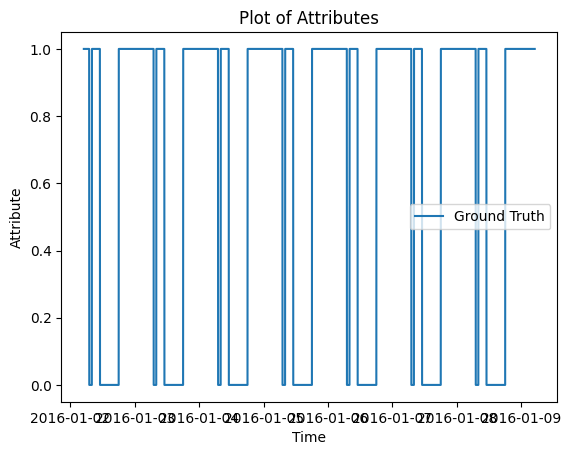

In [59]:
#time = range(len(state_ests))
#ests_df = pd.DataFrame(data=state_ests[:500], index=df.index[:500], columns=['Presence'])
#g = sns.lineplot(data=ests_df).set(title='Estimated presence')
plot_dfs(df, ['Ground Truth'], ['2016-01-02 05:00:00', '2016-01-09 05:00:00'])

Random cross validation

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Split: 0
Train: [9233 5155 6446 ... 8023 1165 2201]
Test [5057 3282  787 ...   88   66  368]
[[  48 1020]
 [  27 1930]]
Learned emission probs:
[[0.47959931 0.51639615 0.00098742 0.00301712]
 [0.42479688 0.57180154 0.00072891 0.00267267]]
------------------------------------
Learned transition matrix:
[[0.46971969 0.53028031]
 [0.46969178 0.53030822]]
Split: 1
Train: [ 1598  7832  3814 ... 10066  1990  6197]
Test [4950 7308 3686 ... 1828 8392 3093]
[[ 993    0]
 [ 394 1638]]
Learned emission probs:
[[0.48634147 0.50934259 0.00115093 0.00316501]
 [0.43134532 0.56499489 0.00085112 0.00280867]]
------------------------------------
Learned transition matrix:
[[0.47008235 0.52991765]
 [0.47008693 0.52991307]]
Split: 2
Train: [9566 5616 3749 ... 6161 7187  576]
Test [8468 1875  799 ... 7611 7546 7673]
[[   3 1011]
 [   1 2010]]
Learned emission probs:
[[0.48787686 0.50827401 0.00098627 0.00286286]
 [0.43291923 0.56380927 0.00072972 0.00254178]]
------------------------------------
Learned tr

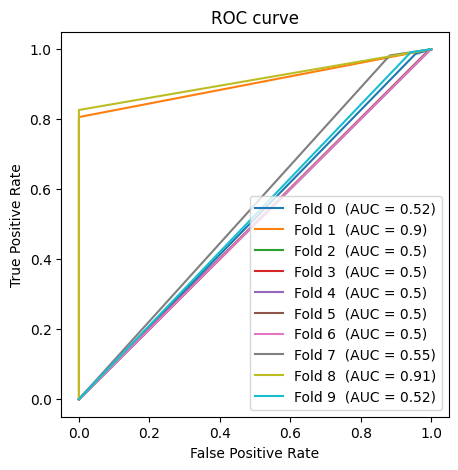

In [60]:
#Markov Chain - 2 (without aggregation) - random cross validation


y_true_original = interval_model(data_frame= df['Ground Truth'], starting_date='2016-01-01 05:00:00', interval=datetime.timedelta(days=7))
ss = ShuffleSplit(n_splits=10, test_size=0.3)

y_true_all = []

def sequence2counts(status, ostates2id):
    ans = []
    for word, idx in ostates2id.items():
       
        count = status.count(word)
        ans.append(count)
    return ans


# Smart home situation states: hidden state
h_states = ['absent', 'present'] # not at home, at home
id2hstates = dict(zip(range(len(h_states)), h_states)) # Dict from numbers to words

# Initial distribution of hidden states
start_probs = np.array([0.5, 0.5])

# microwave and GT: observable states: 
# Pos 1: Default $Df$
# Pos 2: Microvave on off
o_states = ['00', '01', '10', '11']  
id2ostates = dict(zip(o_states, range(len(o_states))))

# Transition probs from hidden to observable states
emission_probs = np.array([[0.25, 0.2, 0.3, 0.25],
                           [0.25, 0.25, 0.25, 0.25]])

# Transition matrix of hidden states
trans_mat = np.array([[0.5, 0.5], [0.5, 0.5]])

observations = df_model.values.tolist()


# Format observations
X = []
for status in observations:
    row = sequence2counts(status, id2ostates)
    X.append(row)
data = np.array(X, dtype=int)


n_trials = len(observations[0])



# Build the model
# Set up model:
model_2 = hmm.MultinomialHMM(n_components=len(h_states),
        n_trials=n_trials-1, init_params='')

model_2.n_features = len(o_states)


model_2.startprob_ = start_probs
model_2.transmat_ = trans_mat
model_2.emissionprob_ = emission_probs




x = data
y = y_true_original.to_numpy()

fig, ax = plt.subplots(figsize=(5, 5))



for split_number, (train_index, test_index) in enumerate(ss.split(x, y)):
    
    print("Split:", split_number)

    #print("Start: ", model.startprob_, "Transmission: ", model.transmat_, "Emission :", model.emissionprob_)
    
    
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

    print("Train:", train_index)
    print("Test", test_index)

    X_train = X_train.astype(int)

    # Fit the model and predict probabilities for the test set
    model_2.fit(X_train)
    logprob, state_ests = model_2.decode(X_test)

    y_pred_proba = state_ests

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    print(confusion_matrix(y[test_index], y_pred_proba))

    # Plot the ROC curve for the current fold
    ax.plot(fpr, tpr, label='Fold {}  (AUC = {})'.format(split_number, round(auc_score,2)))

    

    print("Learned emission probs:")
    print(model_2.emissionprob_)
    print('------------------------------------')
    print("Learned transition matrix:")
    print(model_2.transmat_)

    

# Plot the ROC curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()
plt.show()

Daily cross validation

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


[0 1 0 0]
(10081, 4)
[3, 1, 5, 6, 7]
[2, 4]
0
[1 1 1 ... 1 1 1]
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
[[ 960    0]
 [ 360 1560]]
Learned emission probs:
[[9.98787879e-01 1.18622734e-13 1.21212121e-03 4.64851031e-25]
 [2.21019870e-12 9.93846154e-01 3.45413449e-27 6.15384615e-03]]
------------------------------------
Learned transition matrix:
[[0.99848485 0.00151515]
 [0.00128238 0.99871762]]
1
[1 1 1 ... 1 1 1]
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
[[ 960    0]
 [ 360 1560]]
Learned emission probs:
[[9.98787879e-01 1.10424241e-18 1.21212121e-03 2.46371208e-36]
 [1.45919720e-17 9.93846154e-01 9.39328848e-39 6.15384615e-03]]
------------------------------------
Learned transition matrix:
[[0.99848485 0.00151515]
 [0.00128238 0.99871762]]
2
[1 1 1 ... 1 1 1]
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
[[ 960    0]
 [ 360 1560]]
Learned emission probs:
[[9.98787879e-01 1.02792379e-23 1.21212121e-03 1.30576825e-47]
 [9.63377854e-23 9.93846154e-01 2.55444218e

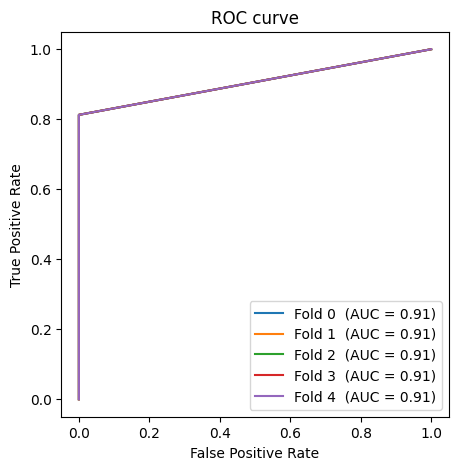

In [61]:
#Markov Chain - 2 (without aggregation) - specific cross validation

y_true_original = interval_model(data_frame= df['Ground Truth'], starting_date='2016-01-01 05:00:00', interval=datetime.timedelta(days=7))


y_true_all_2 = []

y_pred_proba_all_2 = []
y_true_all = []

def sequence2counts(status, ostates2id):
    ans = []
    for word, idx in ostates2id.items():
       
        count = status.count(word)
        ans.append(count)
    return ans


# Smart home situation states: hidden state
h_states = ['absent', 'present'] # not at home, at home
id2hstates = dict(zip(range(len(h_states)), h_states)) # Dict from numbers to words

# Initial distribution of hidden states
start_probs = np.array([0.5, 0.5])

# microwave and GT: observable states: 
# Pos 1: Default $Df$
# Pos 2: Microvave on off
o_states = ['00', '01', '10', '11']  
id2ostates = dict(zip(o_states, range(len(o_states))))

# Transition probs from hidden to observable states
emission_probs = np.array([[0.25, 0.1, 0.4, 0.25],
                           [0.2, 0.5, 0.1, 0.2]])

# Transition matrix of hidden states
trans_mat = np.array([[0.95, 0.05], [0.05, 0.95]])

observations = df_model.values.tolist()


# Format observations
X = []
for status in observations:
    row = sequence2counts(status, id2ostates)
    X.append(row)
data = np.array(X, dtype=int)


n_trials = len(observations[0])


print(data[0])


# Build the model
# Set up model:
model = hmm.MultinomialHMM(n_components=len(h_states),
        n_trials=n_trials-1, init_params='',)

model.n_features = len(o_states)

model.startprob_ = start_probs
model.transmat_ = trans_mat
model.emissionprob_ = emission_probs




x = data
y = y_true_original.to_numpy()

fig, ax = plt.subplots(figsize=(5, 5))


print(x.shape)
train_days = 5
test_days = 2

# Calculate the total number of minutes in the data
total_minutes = len(x)

day = 24*60
n_splits = 5


random_numbers = random.sample(list(range(1,8)), 5)

not_included = [num for num in list(range(1,8)) if num not in random_numbers]

print(random_numbers)
print(not_included)

for n in range(n_splits):
    print(n)


    start = random_numbers[0]
    X_train = x[(start-1)*day:start*day]
    y_train = y[(start-1)*day:start*day]

    start_not = not_included[0]
    X_test = x[(start_not-1)*day:start_not*day]
    y_test = y[(start_not-1)*day:start_not*day]


    # Perform the train-test split
    for i in random_numbers[1:]:
        X_train = np.vstack((X_train, x[(i-1)*day:i*day]))
        y_train = np.vstack((y_train, y[(i-1)*day:i*day]))

    for i in not_included[1:]:
        X_test = np.vstack((X_test, x[(i-1)*day:i*day]))
        y_test = np.vstack((y_test, y[(i-1)*day:i*day]))

    # Convert the data to the desired type
    X_train = X_train.astype(int)

    # Fit the model and predict probabilities for the test set
    model.fit(X_train)
    logprob, state_ests = model.decode(X_test)

    y_pred_proba = state_ests

    print(state_ests)
    print(y_test)


    # Compute ROC curve and AUC score
    # Compute ROC curve and AUC score
    fpr, tpr, _ = roc_curve(np.ravel(y_test), y_pred_proba)

    auc_score = roc_auc_score(np.ravel(y_test), y_pred_proba)


    ax.plot(fpr, tpr, label='Fold {}  (AUC = {})'.format(n, round(auc_score, 2)))

    # Print confusion matrix
    y_pred = np.round(y_pred_proba)
    print(confusion_matrix(np.ravel(y_test), np.ravel(y_pred)))

    print("Learned emission probs:")
    print(model.emissionprob_)
    print('------------------------------------')
    print("Learned transition matrix:")
    print(model.transmat_)




# Plot the ROC curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()
plt.show()

StratifiedKFold validation 

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Split: 0
[[336   0]
 [129 544]]
Learned emission probs:
[[9.97833935e-01 1.73575271e-13 2.16606498e-03 8.90263358e-28]
 [2.03586518e-14 9.95118975e-01 2.28705397e-29 4.88102502e-03]]
------------------------------------
Learned transition matrix:
[[0.99831528 0.00168472]
 [0.00142392 0.99857608]]
Split: 1
[[336   0]
 [130 542]]
Learned emission probs:
[[9.97833414e-01 6.76213292e-21 2.16658642e-03 2.22813926e-44]
 [4.73799018e-22 9.94714373e-01 1.92061206e-46 5.28562716e-03]]
------------------------------------
Learned transition matrix:
[[0.99831488 0.00168512]
 [0.00142334 0.99857666]]
Split: 2
[[336   0]
 [123 549]]
Learned emission probs:
[[9.98317712e-01 2.62330470e-28 1.68228791e-03 5.30207826e-61]
 [1.10629628e-29 9.94503257e-01 1.26290232e-63 5.49674267e-03]]
------------------------------------
Learned transition matrix:
[[0.99831771 0.00168229]
 [0.00142537 0.99857463]]
Split: 3
[[336   0]
 [121 551]]
Learned emission probs:
[[9.98558732e-01 1.01520055e-35 1.44126832e-03 1.0

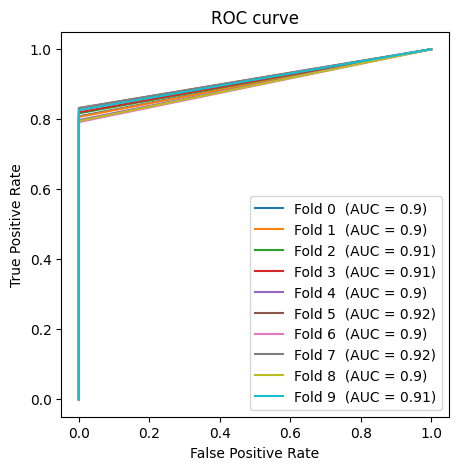

In [62]:
y_true_original = interval_model(data_frame= df['Ground Truth'], starting_date='2016-01-01 05:00:00', interval=datetime.timedelta(days=7))
ss = ShuffleSplit(n_splits=10, test_size=0.3)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=2)

y_true_all = []

def sequence2counts(status, ostates2id):
    ans = []
    for word, idx in ostates2id.items():
       
        count = status.count(word)
        ans.append(count)
    return ans


# Smart home situation states: hidden state
h_states = ['absent', 'present'] # not at home, at home
id2hstates = dict(zip(range(len(h_states)), h_states)) # Dict from numbers to words

# Initial distribution of hidden states
start_probs = np.array([0.7, 0.3])

# microwave and GT: observable states: 
# Pos 1: Default $Df$
# Pos 2: Microvave on off
o_states = ['00', '01', '10', '11']  
id2ostates = dict(zip(o_states, range(len(o_states))))

# Transition probs from hidden to observable states
emission_probs = np.array([[0.4, 0.1, 0.4, 0.1],
                           [0.25, 0.25, 0.25, 0.25]])

# Transition matrix of hidden states
trans_mat = np.array([[0.8, 0.2], [0.5, 0.5]])

observations = df_model.values.tolist()


# Format observations
X = []
for status in observations:
    row = sequence2counts(status, id2ostates)
    X.append(row)
data = np.array(X, dtype=int)


n_trials = len(observations[0])



# Build the model
# Set up model:
model_2 = hmm.MultinomialHMM(n_components=len(h_states),
        n_trials=n_trials-1, init_params='')

model_2.n_features = len(o_states)


model_2.startprob_ = start_probs
model_2.transmat_ = trans_mat
model_2.emissionprob_ = emission_probs




x = data
y = y_true_original.to_numpy()

fig, ax = plt.subplots(figsize=(5, 5))



for split_number, (train_index, test_index) in enumerate(skf.split(x, y)):
    
    print("Split:", split_number)

    #print("Start: ", model.startprob_, "Transmission: ", model.transmat_, "Emission :", model.emissionprob_)
    
    
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]


    X_train = X_train.astype(int)

    # Fit the model and predict probabilities for the test set
    model_2.fit(X_train)
    logprob, state_ests = model_2.decode(X_test)

    y_pred_proba = state_ests

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    print(confusion_matrix(y[test_index], y_pred_proba))

    # Plot the ROC curve for the current fold
    ax.plot(fpr, tpr, label='Fold {}  (AUC = {})'.format(split_number, round(auc_score,2)))

    

    print("Learned emission probs:")
    print(model_2.emissionprob_)
    print('------------------------------------')
    print("Learned transition matrix:")
    print(model_2.transmat_)

    

# Plot the ROC curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()
plt.show()

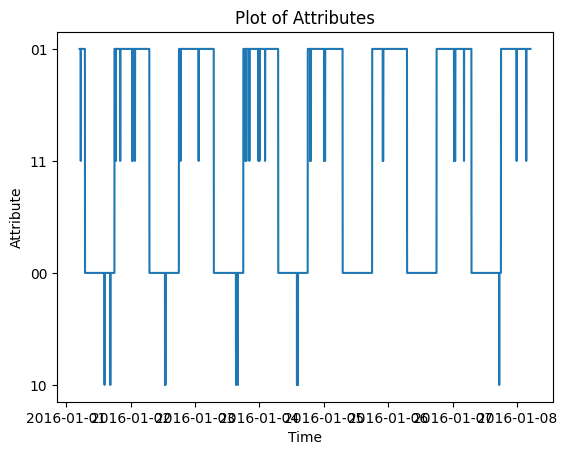

In [63]:
# Graph of input before oversampling
plot_dfs(df, 'Microwave - Default (combined)', [y_true_original.index[0], y_true_original.index[-1]])

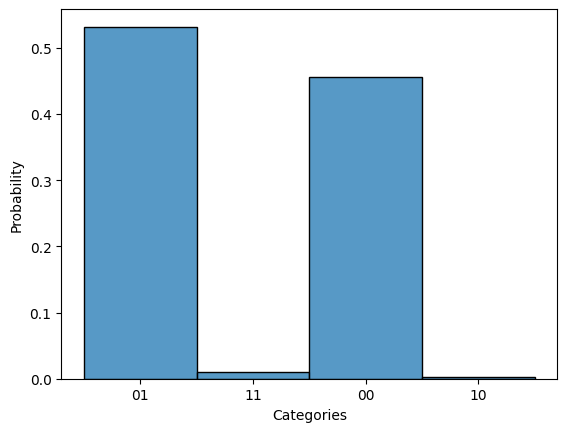

In [64]:
# Histogram 
data = df['Microwave - Default (combined)'].loc[y_true_original.index[0]:y_true_original.index[-1]]
fig, ax = plt.subplots()
sns.histplot(data, ax=ax, stat='probability', discrete=True)
plt.xlabel('Categories')
plt.ylabel('Probability')
plt.show()


In [65]:
# This is how the oversampling is performed

i = 0
while i < 10080:
    if df['Microwave - Default (combined)'].iloc[i] == '11':
        df.loc[i:i+170, 'Microwave - Default (combined)'] = '11'
        i += 200
    if df['Microwave - Default (combined)'].iloc[i] == '10':
        df.loc[i:i+250, 'Microwave - Default (combined)'] = '10'
        i += 270
    else:
        i += 1


/tmp/ipykernel_88138/3675720036.py:6: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[i:i+170, 'Microwave - Default (combined)'] = '11'
/tmp/ipykernel_88138/3675720036.py:9: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[i:i+250, 'Microwave - Default (combined)'] = '10'


<AxesSubplot: xlabel='Microwave - Default (combined)', ylabel='Count'>

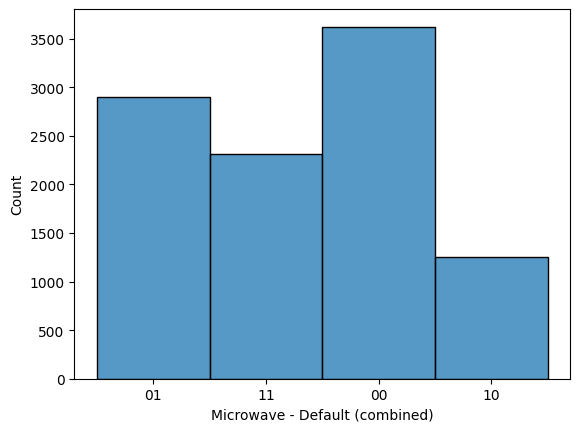

In [66]:
# Histogram after oversampling
sns.histplot(df['Microwave - Default (combined)'].loc[y_true_original.index[0] :  y_true_original.index[-1]])

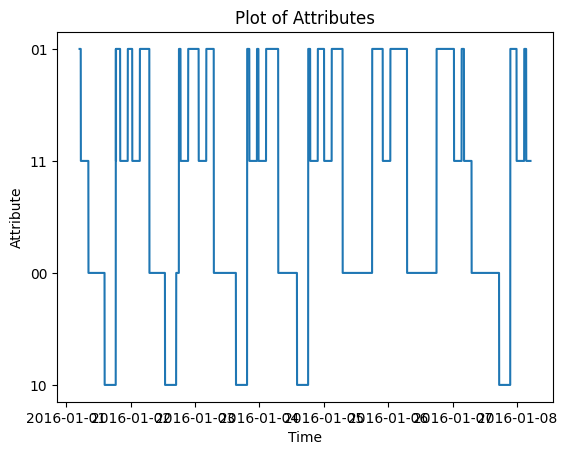

In [67]:
# Graph of input after oversampling
plot_dfs(df, 'Microwave - Default (combined)', [y_true_original.index[0], y_true_original.index[-1]])

StratifiedKFold validation after oversampling

MultinomialHMM has undergone major changes. The previous version was implementing a CategoricalHMM (a special case of MultinomialHMM). This new implementation follows the standard definition for a Multinomial distribution (e.g. as in https://en.wikipedia.org/wiki/Multinomial_distribution). See these issues for details:
https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


Split: 0
Train: [    0     1     2 ... 10078 10079 10080]
Test [    6     9    17 ... 10051 10063 10070]
[[336   0]
 [130 543]]
Learned emission probs:
[[0.49556223 0.50043737 0.00118474 0.00281567]
 [0.4227947  0.57388977 0.00082106 0.00249447]]
------------------------------------
Learned transition matrix:
[[0.48964562 0.51035438]
 [0.45290427 0.54709573]]
Split: 1
Train: [    1     3     5 ... 10078 10079 10080]
Test [    0     2     4 ... 10023 10047 10074]
[[336   0]
 [130 542]]
Learned emission probs:
[[6.81754266e-01 3.13947432e-01 1.65391291e-03 2.64438951e-03]
 [2.54698079e-01 7.41840440e-01 3.96962201e-04 3.06451788e-03]]
------------------------------------
Learned transition matrix:
[[0.65307131 0.34692869]
 [0.3118942  0.6881058 ]]
Split: 2
Train: [    0     2     3 ... 10078 10079 10080]
Test [    1     5    30 ... 10040 10046 10050]
[[336   0]
 [123 549]]
Learned emission probs:
[[9.98317712e-01 3.64424591e-12 1.68228791e-03 1.13704562e-23]
 [1.00617633e-12 9.94503257e-

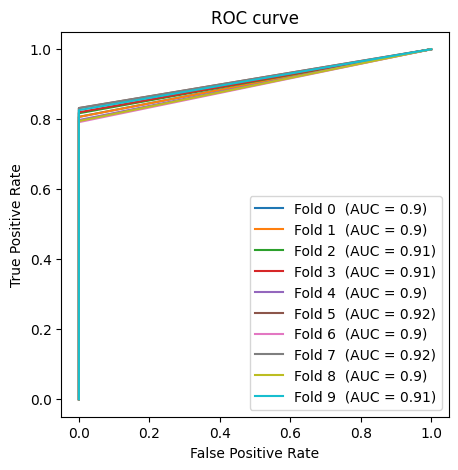

In [68]:
y_true_original = interval_model(data_frame= df['Ground Truth'], starting_date='2016-01-01 05:00:00', interval=datetime.timedelta(days=7))
#ss = ShuffleSplit(n_splits=10, test_size=0.3)

y_true_all = []

def sequence2counts(status, ostates2id):
    ans = []
    for word, idx in ostates2id.items():
       
        count = status.count(word)
        ans.append(count)
    return ans


# Smart home situation states: hidden state
h_states = ['absent', 'present'] # not at home, at home
id2hstates = dict(zip(range(len(h_states)), h_states)) # Dict from numbers to words

# Initial distribution of hidden states
start_probs = np.array([0.9, 0.1])

# microwave and GT: observable states: 
# Pos 1: Default $Df$
# Pos 2: Microvave on off
o_states = ['00', '01', '10', '11']  
id2ostates = dict(zip(o_states, range(len(o_states))))

# Transition probs from hidden to observable states
emission_probs = np.array([[0.25, 0.2, 0.3, 0.25],
                           [0.25, 0.25, 0.25, 0.25]])

# Transition matrix of hidden states
trans_mat = np.array([[0.5, 0.5], [0.5, 0.5]])

observations = df_model.values.tolist()


# Format observations
X = []
for status in observations:
    row = sequence2counts(status, id2ostates)
    X.append(row)
data = np.array(X, dtype=int)


n_trials = len(observations[0])



# Build the model
# Set up model:
model_2 = hmm.MultinomialHMM(n_components=len(h_states),
        n_trials=n_trials-1, init_params='')

model_2.n_features = len(o_states)


model_2.startprob_ = start_probs
model_2.transmat_ = trans_mat
model_2.emissionprob_ = emission_probs




x = data
y = y_true_original.to_numpy()

fig, ax = plt.subplots(figsize=(5, 5))



for split_number, (train_index, test_index) in enumerate(skf.split(x, y)):
    
    print("Split:", split_number)

    #print("Start: ", model.startprob_, "Transmission: ", model.transmat_, "Emission :", model.emissionprob_)
    
    
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

    print("Train:", train_index)
    print("Test", test_index)

    X_train = X_train.astype(int)

    # Fit the model and predict probabilities for the test set
    model_2.fit(X_train)
    logprob, state_ests = model_2.decode(X_test)

    y_pred_proba = state_ests

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)

    print(confusion_matrix(y[test_index], y_pred_proba))

    # Plot the ROC curve for the current fold
    ax.plot(fpr, tpr, label='Fold {}  (AUC = {})'.format(split_number, round(auc_score,2)))

    

    print("Learned emission probs:")
    print(model_2.emissionprob_)
    print('------------------------------------')
    print("Learned transition matrix:")
    print(model_2.transmat_)

    

# Plot the ROC curve
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()
plt.show()